# Hot Plasma Paper: Figures Testbed
Testing figure construction for chapter on hot plasma.

In [17]:
import sys
import os
from collections import OrderedDict
import copy
import pickle
from fractions import Fraction

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter, MaxNLocator, LogLocator
import astropy.units as u
import seaborn
from synthesizAR.atomic import Element

sys.path.append('../thesis/python/')
from run_ebtel import run_ebtel
from dem import calculate_em, fit_slope, plot_hist

%matplotlib inline

In [18]:
# Base ebtel++ configuration
base_config = {
    'total_time': 5e3,
    'tau': 0.1,
    'tau_max': 10,
    'loop_length': 4e9,
    'saturation_limit': 1,
    'force_single_fluid': False,
    'use_c1_loss_correction': True,
    'use_c1_grav_correction': True,
    'use_flux_limiting': True,
    'use_power_law_radiative_losses': True,
    'calculate_dem': False,
    'save_terms': False,
    'use_adaptive_solver': False,
    'adaptive_solver_error': 1e-8,
    'adaptive_solver_safety': 0.5,
    'c1_cond0': 6.0,
    'c1_rad0': 0.6,
    'helium_to_hydrogen_ratio': 0.075,
    'surface_gravity': 1.0,
    'heating': OrderedDict({
        'partition': 1.,
        'background': 3.5e-5,}),
}
# Simulation parameters
total_energy = 10.0
durations = [20.0, 40.0, 200.0, 500.0]
flux_limiters = [
    (1.0, True),
    (0.53, True),
    (1.0/6.0, True),
    (0.1, True),
    (1.0/30.0, True),
    (1.0, False)
]
PALETTE = seaborn.color_palette('colorblind')
bins_T = 10**(np.arange(4, 8.5, 0.01))*u.K

## Single-fluid 

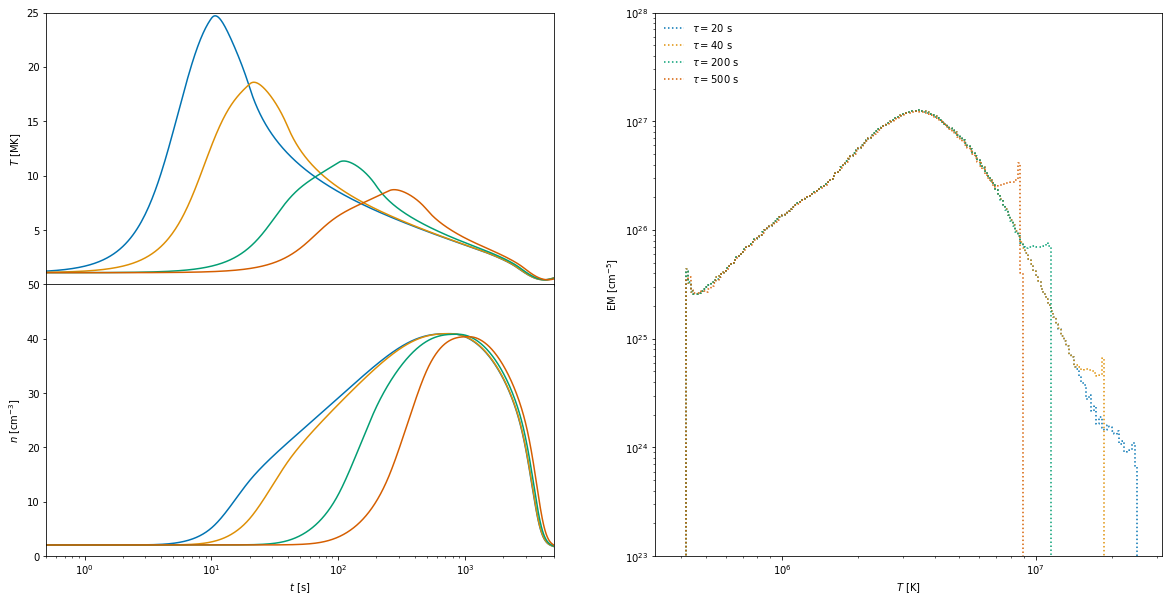

In [6]:
fig = plt.figure(figsize=(20,10))
ax1 = plt.subplot2grid((2,2),(0,0))
ax2 = plt.subplot2grid((2,2),(1,0))
ax3 = plt.subplot2grid((2,2),(0,1),rowspan=2)
for i,tau in enumerate(durations):
    # Configure EBTEL run
    config = copy.deepcopy(base_config)
    config['force_single_fluid'] = True
    config['heating']['partition'] = 0.5
    config['heating']['events'] = [{'event': {
        'magnitude': 2*total_energy/tau,
        'rise_start': 0.,
        'rise_end': tau/2.,
        'decay_start': tau/2.,
        'decay_end': tau,
    }}]
    res = run_ebtel(config, '/Users/willbarnes/Documents/work/codes/ebtelPlusPlus/')
    # Plot temperature and density
    ax1.plot(res['time'], res['electron_temperature'].to(u.MK),color=PALETTE[i])
    ax2.plot(res['time'], res['density']/1e8,color=PALETTE[i],)
    # Plot emission measure
    bins, em = calculate_em(
        res['time'],
        res['electron_temperature'],
        res['density'],
        2*config['loop_length'],
        bins_T=bins_T,
    )
    plot_hist(ax3, em.value, bins.value, color=PALETTE[i], label=f'$\\tau={tau:.0f}$ s',
              linestyle=':')
    
# Limits and scales
ax1.set_xlim(0.5,config['total_time'])
ax2.set_xlim(0.5,config['total_time'])
ax1.set_ylim(0,25)
ax2.set_ylim(0,50)
ax1.set_xscale('log')
ax2.set_xscale('log')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_ylim([1e+23, 1e+28])
ax3.set_xlim([10**5.5, 10**7.5])
ax1.xaxis.set_major_formatter(NullFormatter())
ax1.yaxis.set_major_locator(MaxNLocator(nbins=5,prune='lower'))
ax3.legend(frameon=False,loc=2)
# Labels
ax1.set_ylabel(r'$T$ [MK]')
ax2.set_ylabel(r'$n$ [cm$^{-3}$]')
ax2.set_xlabel(r'$t$ [s]')
ax3.set_ylabel(r'EM [cm$^{-5}$]')
ax3.set_xlabel(r'$T$ [K]')
plt.subplots_adjust(hspace=0.)

## Heat flux limiting

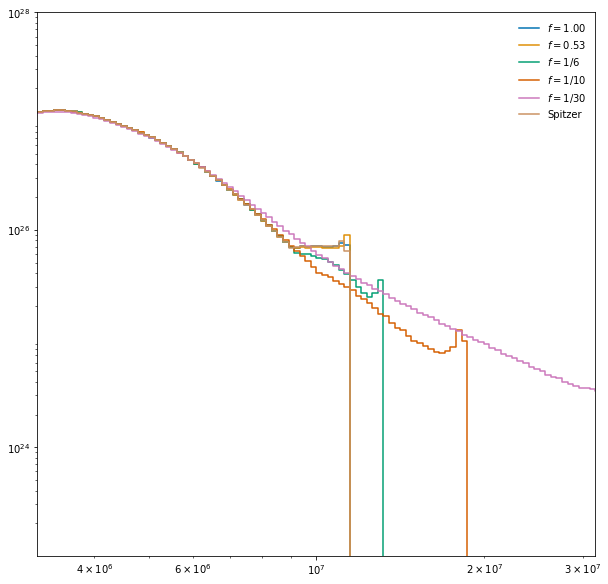

In [7]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
for i,fl in enumerate(flux_limiters):
    config = copy.deepcopy(base_config)
    config['force_single_fluid'] = True
    config['heating']['partition'] = 0.5
    config['heating']['events'] = [{'event': {
        'magnitude': 2*total_energy/200.0,
        'rise_start': 0.,
        'rise_end': 200.0/2.,
        'decay_start': 200.0/2.,
        'decay_end': 200.0,
    }}]
    config['saturation_limit'] = fl[0]
    config['use_flux_limiting'] = fl[1]
    res = run_ebtel(config, '/Users/willbarnes/Documents/work/codes/ebtelPlusPlus/')
    bins, em = calculate_em(
        res['time'],
        res['electron_temperature'],
        res['density'],
        2*config['loop_length'],
        bins_T=bins_T,
    )
    if fl[1]:
        frac = Fraction(fl[0]).limit_denominator()
        if frac.numerator == 1 and frac.denominator != 1:
            label = r'$f=$' + f'{frac.numerator:.0f}/{frac.denominator:.0f}'
        else:
            label = r'$f=$' + f'{fl[0]:.2f}'
    else:
        label='Spitzer'
    plot_hist(ax, em.value, bins.value, color=PALETTE[i],
              label=label, linestyle='-')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e+23, 1e+28])
ax.set_xlim([10**6.5, 10**7.5])
ax.legend(frameon=False,loc=1)
ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=3))
ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=1))

## Phase Space

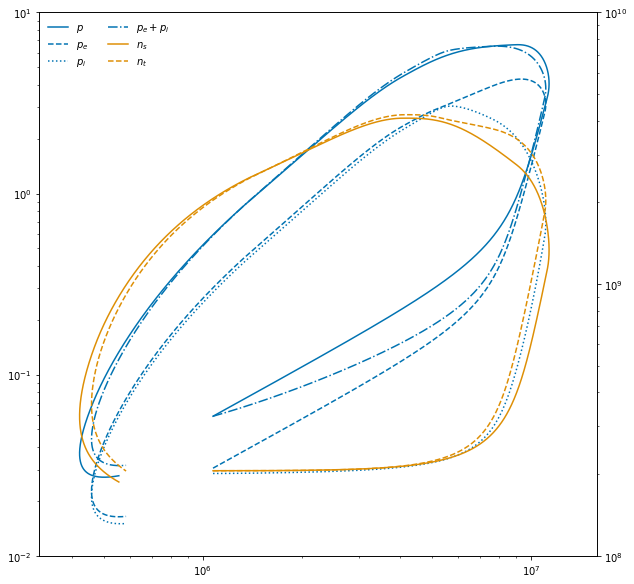

In [57]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax2 = ax.twinx()
# Single fluid
config = copy.deepcopy(base_config)
config['force_single_fluid'] = True
config['heating']['partition'] = 0.5
config['heating']['events'] = [{'event': {
    'magnitude': 2*total_energy/durations[2],
    'rise_start': 0.,
    'rise_end': durations[2]/2.,
    'decay_start': durations[2]/2.,
    'decay_end': durations[2],
}}]
res_sf = run_ebtel(config, '/Users/willbarnes/Documents/work/codes/ebtelPlusPlus/')
# Two fluid
config['force_single_fluid'] = False
config['heating']['partition'] = 1.0
res_tf = run_ebtel(config, '/Users/willbarnes/Documents/work/codes/ebtelPlusPlus/')
# Plot pressure
lnp = ax.plot(res_sf['electron_temperature'], res_sf['electron_pressure']+res_sf['ion_pressure'], color=PALETTE[0], ls='-', label=r'$p$')
lnpe = ax.plot(res_tf['electron_temperature'], res_tf['electron_pressure'], color=PALETTE[0], ls='--', label=r'$p_e$')
lnpi = ax.plot(res_tf['electron_temperature'], res_tf['ion_pressure'], color=PALETTE[0], ls=':', label=r'$p_i$')
lnpepi = ax.plot(res_tf['electron_temperature'], res_tf['electron_pressure']+res_tf['ion_pressure'], color=PALETTE[0],
        ls='-.', label=r'$p_e+p_i$')
# Plot density
lnns = ax2.plot(res_sf['electron_temperature'], res_sf['density'], color=PALETTE[1], ls='-', label=r'$n_s$')
lnnt = ax2.plot(res_tf['electron_temperature'], res_tf['density'], color=PALETTE[1], ls='--', label=r'$n_t$')
# Scales
ax.set_xscale('log')
ax2.set_xscale('log')
ax.set_yscale('log')
ax2.set_yscale('log')
# Limits
ax.set_xlim([10**5.5,10**7.2])
ax2.set_xlim([10**5.5,10**7.2])
ax.set_ylim(1e-2,1e1)
ax2.set_ylim(1e8,1e10)
# Labels
# Legend
lines = lnp + lnpe + lnpi + lnpepi + lnns + lnnt
labels = [l.get_label() for l in lines]
ax.legend(lines,labels,loc=2,frameon=False,ncol=2)

## NEI

In [3]:
def effective_temperature(ieq, nei, T):
    return T[[(np.fabs(ieq - nei[i,:])).sum(axis=1).argmin() for i in range(nei.shape[0])]]

In [4]:
T_grid = np.logspace(4,8.5,1000)*u.K
fe = Element('iron', T_grid)
ieq = fe.equilibrium_ionization()
rate_matrix = fe._rate_matrix()

/Users/willbarnes/anaconda/envs/dissertation/lib/python3.7/site-packages/synthesizAR-0.1.dev862-py3.7.egg/synthesizAR/atomic/chianti.py:66: RuntimeWarning: divide by zero encountered in true_divide
  if np.logical_or(y[1:, :]/y[:-1, :] > 10**(eps_r), y[1:, :]/y[:-1, :] < 10**(-eps_r)).any():
/Users/willbarnes/anaconda/envs/dissertation/lib/python3.7/site-packages/synthesizAR-0.1.dev862-py3.7.egg/synthesizAR/atomic/chianti.py:67: UserWarning: Condition 2 of Macneice et al. (1984) is not satisfied. Consider choosing a smaller timestep.
  warnings.warn('Condition 2 of Macneice et al. (1984) is not satisfied. Consider '
/Users/willbarnes/anaconda/envs/dissertation/lib/python3.7/site-packages/synthesizAR-0.1.dev862-py3.7.egg/synthesizAR/atomic/chianti.py:67: UserWarning: Condition 2 of Macneice et al. (1984) is not satisfied. Consider choosing a smaller timestep.
  warnings.warn('Condition 2 of Macneice et al. (1984) is not satisfied. Consider '
/Users/willbarnes/anaconda/envs/dissertation/

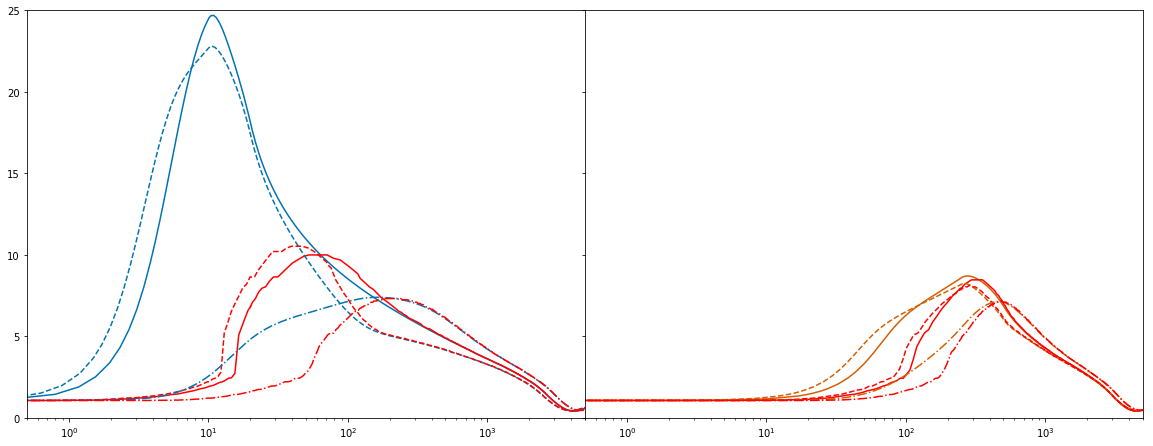

In [5]:
fig = plt.figure(figsize=(20,7.5))
for i,tau in enumerate(np.array(durations)[[0,-1]]):
    ax = fig.add_subplot(1,2,i+1)
    j = np.argmin(np.fabs(np.array(durations) - tau))
    for p,b,ls in [(0.5, True, '-'), (1, False, '--'), (0, False, '-.')]:
        config = copy.deepcopy(base_config)
        config['use_adaptive_solver'] = True
        config['force_single_fluid'] = b
        config['heating']['partition'] = p
        config['heating']['events'] = [{'event': {
            'magnitude': 2*total_energy/tau,
            'rise_start': 0.,
            'rise_end': tau/2.,
            'decay_start': tau/2.,
            'decay_end': tau,
        }}]
        res = run_ebtel(config, '/Users/willbarnes/Documents/work/codes/ebtelPlusPlus/')
        # Temperature
        ax.plot(res['time'], res['electron_temperature'].to(u.MK), ls=ls, color=PALETTE[j])
        # Effective temperature
        nei = fe.non_equilibrium_ionization(res['time'],res['electron_temperature'],res['density'],
                                            rate_matrix=rate_matrix,initial_condition=ieq,
                                            check_solution=True)
        Teff = effective_temperature(ieq,nei,T_grid)
        ax.plot(res['time'],Teff.to(u.MK),ls=ls,color='r')
    ax.set_xscale('log')
    ax.set_xlim(0.5,config['total_time'])
    ax.set_ylim(0,25)
    if i != 0:
        ax.yaxis.set_major_formatter(NullFormatter())
plt.subplots_adjust(wspace=0)

/Users/willbarnes/anaconda/envs/dissertation/lib/python3.7/site-packages/synthesizAR-0.1.dev862-py3.7.egg/synthesizAR/atomic/chianti.py:67: UserWarning: Condition 2 of Macneice et al. (1984) is not satisfied. Consider choosing a smaller timestep.
  warnings.warn('Condition 2 of Macneice et al. (1984) is not satisfied. Consider '
/Users/willbarnes/anaconda/envs/dissertation/lib/python3.7/site-packages/synthesizAR-0.1.dev862-py3.7.egg/synthesizAR/atomic/chianti.py:67: UserWarning: Condition 2 of Macneice et al. (1984) is not satisfied. Consider choosing a smaller timestep.
  warnings.warn('Condition 2 of Macneice et al. (1984) is not satisfied. Consider '
/Users/willbarnes/anaconda/envs/dissertation/lib/python3.7/site-packages/synthesizAR-0.1.dev862-py3.7.egg/synthesizAR/atomic/chianti.py:67: UserWarning: Condition 2 of Macneice et al. (1984) is not satisfied. Consider choosing a smaller timestep.
  warnings.warn('Condition 2 of Macneice et al. (1984) is not satisfied. Consider '
/Users/

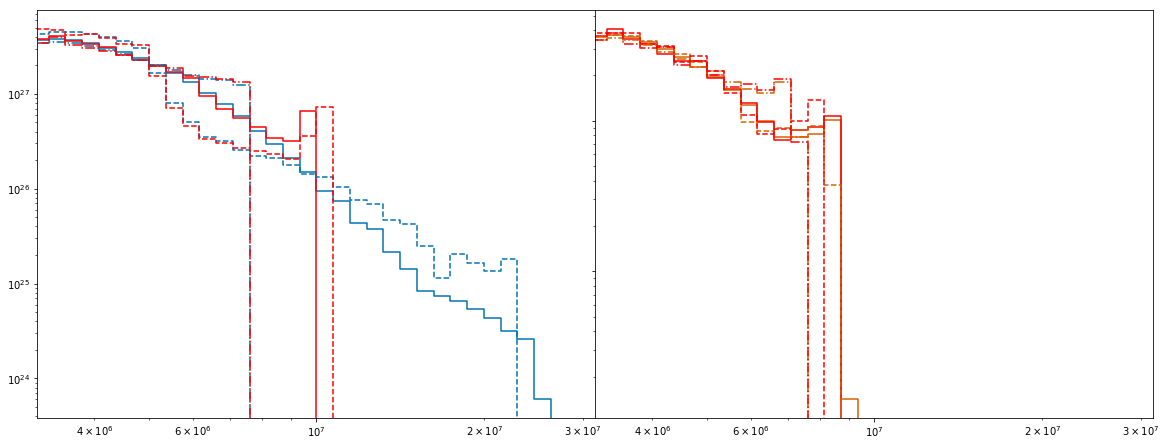

In [16]:
bins_T = 10**(np.arange(4, 8.5, 0.03))*u.K
fig = plt.figure(figsize=(20,7.5))
for i,tau in enumerate(np.array(durations)[[0,-1]]):
    ax = fig.add_subplot(1,2,i+1)
    j = np.argmin(np.fabs(np.array(durations) - tau))
    for p,b,ls in [(0.5, True, '-'), (1, False, '--'), (0, False, '-.')]:
        config = copy.deepcopy(base_config)
        config['use_adaptive_solver'] = True
        config['force_single_fluid'] = b
        config['heating']['partition'] = p
        config['heating']['events'] = [{'event': {
            'magnitude': 2*total_energy/tau,
            'rise_start': 0.,
            'rise_end': tau/2.,
            'decay_start': tau/2.,
            'decay_end': tau,
        }}]
        res = run_ebtel(config, '/Users/willbarnes/Documents/work/codes/ebtelPlusPlus/')
        # Temperature
        bins,em = calculate_em(res['time'], res['electron_temperature'], res['density'],
                               2*config['loop_length'],bins_T=bins_T,interpolate=True)
        plot_hist(ax, em.value, bins.value, color=PALETTE[j], linestyle=ls,)
        # Effective temperature
        nei = fe.non_equilibrium_ionization(res['time'],res['electron_temperature'],res['density'],
                                            rate_matrix=rate_matrix,initial_condition=ieq,
                                            check_solution=True)
        Teff = effective_temperature(ieq,nei,T_grid)
        bins,em = calculate_em(res['time'], Teff, res['density'],
                               2*config['loop_length'],bins_T=bins_T,interpolate=True)
        plot_hist(ax, em.value, bins.value, color='r', linestyle=ls,)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim([10**6.5,10**7.5])
    ax.set_ylim([1e+23,1e+28])
    if i != 0:
        ax.yaxis.set_major_formatter(NullFormatter())
plt.subplots_adjust(wspace=0)

## Plot Terms

In [19]:
config = copy.deepcopy(base_config)
config['force_single_fluid'] = False
config['heating']['partition'] = 1.0
config['heating']['events'] = [{'event': {
    'magnitude': 2*total_energy/200.0,
    'rise_start': 0.,
    'rise_end': 200.0/2.,
    'decay_start': 200.0/2.,
    'decay_end': 200.0,
}}]
config['save_terms'] = True